# GMM en datos de alta resolución espacial
El approach anterior separa los componentes en terminos de resolución, se observó que los componentes de baja resolución no poseen tanta variabilidad como los de alta resolución, por tanto pueden ser bien explicados por sumas de oscilaciones o modos principales con un buen porcentaje. 

Este approach espera capturar peaks importantes a partir de fits de modelos gaussianos, este notebook espera lo siguiente:
- datos en un estado pre procesado, normalizados y separados en componentes

Tiene de objetivo:
- Usar o interpretar los Kappa (y) como distribuciones, tomar o samplear puntos rapidamente y luego correr un GMM sobre esa serie de puntos.



In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.decomposition import IncrementalPCA # Para el PCA
from utils import CustomMinMaxScaler
from utils import filtering

from grav_lens import get_datasets


max_files = 2000
batch_size = 64
home_data = os.path.join("..","data")

train_dataset, val_dataset, test_dataset = get_datasets(
    data_index=1,
    max_files=max_files,
    home=home_data,
    batch_size=batch_size,
    val_split=0.2,
    test_split=0.1,
)

for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)
    print(y_batch.shape)


with open('minmaxscaler.pkl', 'rb') as f:
    minmaxscaler = pickle.load(f)

with open('./pca_models/ipca_low.pkl', 'rb') as f:
    ipca_low = pickle.load(f)


Using data folder: ..\data\1
(64, 128, 128, 3)
(64, 128, 128, 1)


In [13]:
for X_batch, y_batch in train_dataset.take(2):
    
    y_batch = minmaxscaler.transform(y_batch) # [0, 1]
    low_freq_batch, high_freq_batch = filtering.process_batch_filters(y_batch.numpy(), cutoff=0.05)

    # ---- Low Freq ----------------
    # para poder hacer la transformación de PCA, 
    # se hace un stack de la informacion de las imagenes
    # (batch, 128*128)
    # luego el PCA entrega 64 coeficientes
    # -> (batch, 64)
    low_freq_stack = np.vstack([img.reshape(-1, 128*128) for img in low_freq_batch])
    ipca_coef = ipca_low.transform(low_freq_stack) 
    # -----------------------------

    # ------ High Freq ------------------
    

# funciones para Gaussiana

In [14]:
# Puede mejorarse para calcular la estadistica por batch
def calculate_image_stats(image):
    """
    Calcula la media y la desviación estándar de la imagen.
    """
    mean_value = np.mean(image)
    std_value = np.std(image)
    return mean_value, std_value

def apply_threshold(image, mean_value, std_value, threshold=1.0):
    """
    Aplica un umbral a la imagen basado en la media y la desviación estándar.

    Parámetros:
        image (numpy array): Imagen en formato numpy array.
        mean_value (float): Media de los valores de la imagen.
        std_value (float): Desviación estándar de los valores de la imagen.
        threshold (float): Factor de umbral para definir el rango de valores que se mantendrán.

    Retorna:
        image_thresholded (numpy array): Imagen con valores filtrados.
    """
    lower_bound = mean_value - threshold * std_value
    upper_bound = mean_value + threshold * std_value
    
    # Filtrar la imagen utilizando el umbral
    image_thresholded = np.where((image >= lower_bound) & (image <= upper_bound), 0 , image)
    
    return image_thresholded

def generate_points_from_image(image, scale_factor=1000):
    """
    Genera puntos (x, y) a partir de una imagen, donde la cantidad de puntos es proporcional a la intensidad del pixel.
    
    Parámetros:
        image (numpy array): Imagen en formato numpy array (2D).
        scale_factor (int): Factor de escala para determinar cuántos puntos generar proporcionalmente al valor del pixel.
        
    Retorna:
        points (list): Lista de coordenadas (x, y) generadas a partir de los valores de los píxeles.
    """
    points = []
    # Recorrer la imagen y generar puntos proporcionales al valor del pixel
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            value = image[i, j]
            if value > 0:  # Solo considerar los picos no nulos
                n_points = int(value * scale_factor)
                points.extend([(i, j)] * n_points)  # Agregar (i, j) proporcionalmente al valor del pixel
    
    return np.array(points)

In [15]:
img = high_freq_batch[0,:,:,0]

In [16]:
np.min(img)

-0.056441343145331675

In [21]:
mean, std = calculate_image_stats(img)

In [28]:
img_clear = apply_threshold(img, mean, std, 3)

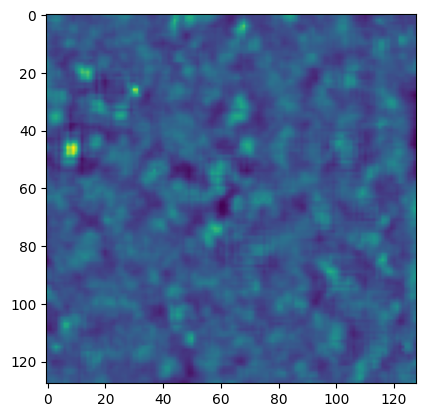

In [29]:
plt.imshow(img)

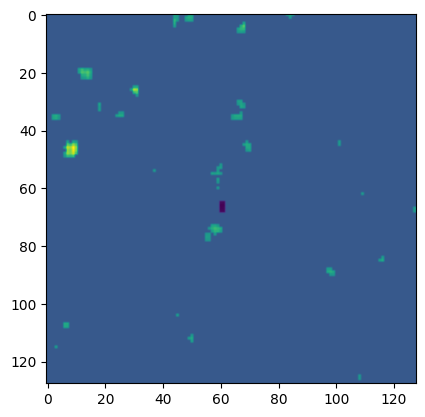

In [30]:
plt.imshow(img_clear)

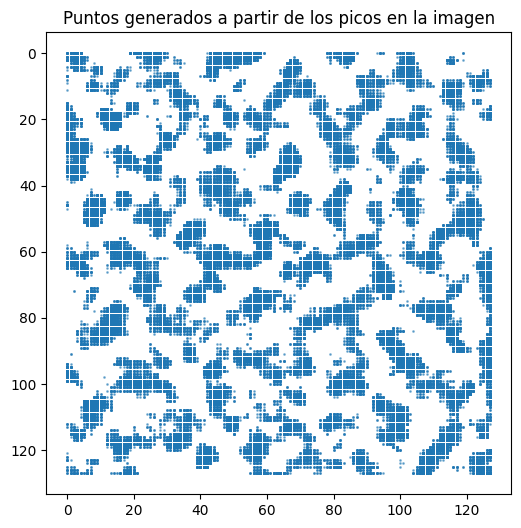

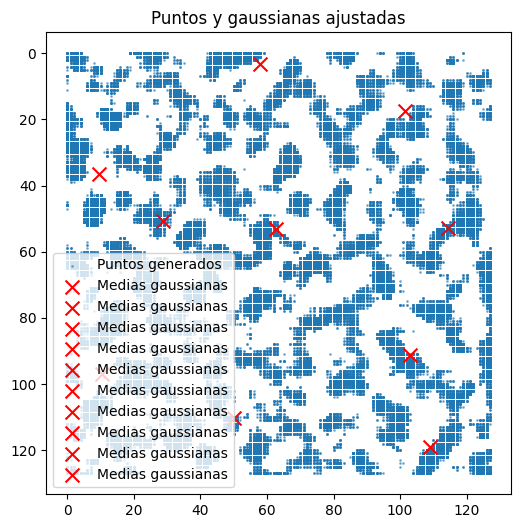

In [19]:
# ----- proceso para 1 sola imagen ------
# Generar los puntos a partir de la imagen
points = generate_points_from_image(high_freq_batch[0,:,:,0])

# Visualización de los puntos generados
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5)
plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
plt.title("Puntos generados a partir de los picos en la imagen")
plt.show()

# --- Ajustar GMM a los puntos generados ---
from sklearn.mixture import GaussianMixture

n_gaussians = 10  # Número de gaussianas para ajustar
gmm = GaussianMixture(n_components=n_gaussians, covariance_type='full').fit(points)

# Visualizar las gaussianas ajustadas
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Visualización de las gaussianas ajustadas sobre los puntos
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 1], points[:, 0], s=1, alpha=0.5, label="Puntos generados")

# Dibujar las gaussianas ajustadas
for mean, cov in zip(means, covariances):
    plt.scatter(mean[1], mean[0], color='red', s=100, marker='x', label="Medias gaussianas")

plt.gca().invert_yaxis()  # Invertir eje y para que coincida con la imagen
plt.title("Puntos y gaussianas ajustadas")
plt.legend()
plt.show()

In [20]:
high_freq_batch.shape

(64, 128, 128, 1)